In [1]:
import os
import numpy as np
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import ResNet152,ResNet50,VGG19,InceptionV3,MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [2]:
def load_images_from_folder(base_path,subpath):
    datasets = {'healthy': {'images': [], 'labels': []},
                'parkinson': {'images': [], 'labels': []}}
    
    for dataset in ['testing', 'training']:
        dataset_path = os.path.join(base_path, subpath, dataset)
        
        for class_label, class_folder in enumerate(['healthy', 'parkinson']):
            class_path = os.path.join(dataset_path, class_folder)
            
            if os.path.isdir(class_path):
                for filename in os.listdir(class_path):
                    img_path = os.path.join(class_path, filename)
                    
                    try:
                        with Image.open(img_path) as img:
                            img = img.convert('RGB')
                            img = img.resize((224, 224))  # Adjust size as needed
                            img_array = np.array(img)
                            datasets[class_folder]['images'].append(img_array)
                            datasets[class_folder]['labels'].append(class_label)
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
    
    # Convert lists to numpy arrays
    for dataset in datasets:
        datasets[dataset]['images'] = np.array(datasets[dataset]['images'])
        datasets[dataset]['labels'] = np.array(datasets[dataset]['labels'])
    
    return datasets


In [3]:
# Usage
base_path = 'D:\Projects\Parkinsons_disease\image_model_v2\data'
datasets_spiral = load_images_from_folder(base_path,'spiral')

# Access healthy and parkinson data separately
X_healthy_spiral, y_healthy_spiral = datasets_spiral['healthy']['images'], datasets_spiral['healthy']['labels']
X_parkinson_spiral, y_parkinson_spiral = datasets_spiral['parkinson']['images'], datasets_spiral['parkinson']['labels']

print(f"Loaded {len(X_healthy_spiral)} healthy images and {len(X_parkinson_spiral)} parkinson images of spiral")
print(f"Image shape: {X_healthy_spiral[0].shape}")
print(f"Number of classes: {len(np.unique(np.concatenate([y_healthy_spiral, y_parkinson_spiral])))}")

Loaded 51 healthy images and 51 parkinson images of spiral
Image shape: (224, 224, 3)
Number of classes: 2


In [4]:
X = np.concatenate([X_healthy_spiral,X_parkinson_spiral],axis=0)
y = np.concatenate([y_healthy_spiral,y_parkinson_spiral],axis=0)
print(f"{X.shape},{y.shape}")

(102, 224, 224, 3),(102,)


In [5]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=0)

In [6]:
print(f"train shape : {x_train.shape},{y_train.shape}")
print(f"val shape   : {x_val.shape},{y_val.shape}")
print(f"test shape  : {x_test.shape},{y_test.shape}")

train shape : (72, 224, 224, 3),(72,)
val shape   : (9, 224, 224, 3),(9,)
test shape  : (21, 224, 224, 3),(21,)


1


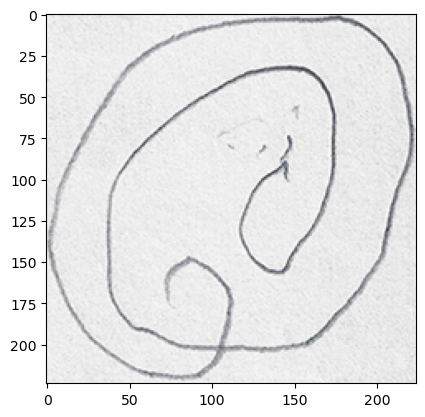

In [7]:
i =8
plt.imshow(x_train[i])
print(y_train[i])

# ResNet152

In [8]:
base_model = ResNet152(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Dense layer for feature extraction
predictions = Dense(1, activation='sigmoid')(x)  # Output layer

resnet152_model = Model(inputs=base_model.input, outputs=predictions)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
for layer in base_model.layers:
    layer.trainable = False
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
resnet152_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
history = resnet152_model.fit(x_train,y_train,epochs=100,batch_size=12,validation_data=(x_val,y_val),callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 58s 5s/step - loss: 0.6604 - accuracy: 0.5694 - val_loss: 0.4927 - val_accuracy: 0.7778
Epoch 2/100
6/6 [==============================] - 17s 3s/step - loss: 0.4641 - accuracy: 0.7778 - val_loss: 0.2884 - val_accuracy: 0.8889
Epoch 3/100
6/6 [==============================] - 18s 3s/step - loss: 0.3404 - accuracy: 0.8472 - val_loss: 0.2814 - val_accuracy: 0.8889
Epoch 4/100
6/6 [==============================] - 20s 3s/step - loss: 0.2889 - accuracy: 0.8611 - val_loss: 0.2194 - val_accuracy: 0.8889
Epoch 5/100
6/6 [==============================] - 23s 4s/step - loss: 0.2595 - accuracy: 0.8889 - val_loss: 0.2277 - val_accuracy: 0.8889
Epoch 6/100
6/6 [==============================] - 18s 3s/step - loss: 0.2320 - accuracy: 0.9028 - val_loss: 0.2104 - val_accuracy: 0.8889
Epoch 7/100
6/6 [==============================] - 18s 3s/step - loss: 0.2332 - accuracy: 0.9306 - val_loss: 0.2004 - val_accuracy: 0.8889
Epoch 8/100
6/6 [==========

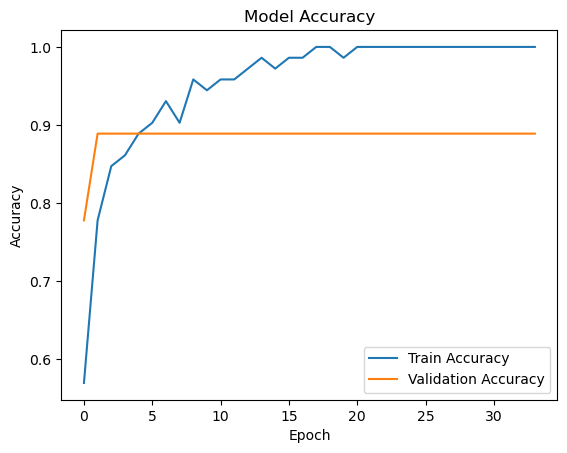

In [10]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

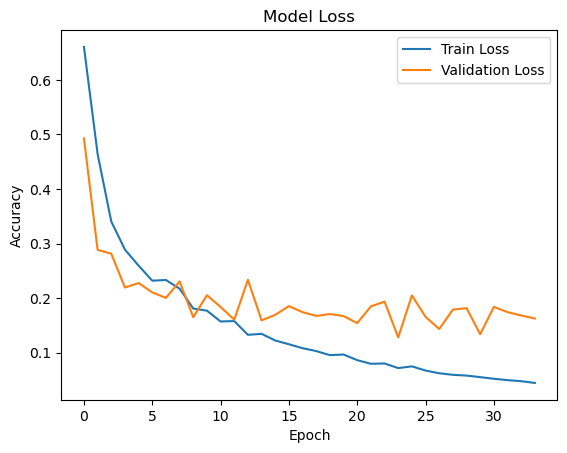

In [11]:
# Plot training & validation accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ResNet50

In [12]:
base_model = ResNet50(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Dense layer for feature extraction
predictions = Dense(1, activation='sigmoid')(x)  # Output layer

resnet50_model = Model(inputs=base_model.input, outputs=predictions)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

for layer in base_model.layers:
    layer.trainable = False

resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [13]:
history = resnet50_model.fit(x_train,y_train,epochs=100,batch_size=12,validation_data=(x_val,y_val),callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 23s 2s/step - loss: 0.6833 - accuracy: 0.5972 - val_loss: 0.4166 - val_accuracy: 0.8889
Epoch 2/100
6/6 [==============================] - 7s 1s/step - loss: 0.4624 - accuracy: 0.8056 - val_loss: 0.3879 - val_accuracy: 0.8889
Epoch 3/100
6/6 [==============================] - 6s 1s/step - loss: 0.4327 - accuracy: 0.7778 - val_loss: 0.3120 - val_accuracy: 0.8889
Epoch 4/100
6/6 [==============================] - 6s 1s/step - loss: 0.3549 - accuracy: 0.8611 - val_loss: 0.2618 - val_accuracy: 0.8889
Epoch 5/100
6/6 [==============================] - 7s 1s/step - loss: 0.3365 - accuracy: 0.8611 - val_loss: 0.2796 - val_accuracy: 0.8889
Epoch 6/100
6/6 [==============================] - 8s 1s/step - loss: 0.3128 - accuracy: 0.8333 - val_loss: 0.2597 - val_accuracy: 0.8889
Epoch 7/100
6/6 [==============================] - 8s 1s/step - loss: 0.2874 - accuracy: 0.8750 - val_loss: 0.2527 - val_accuracy: 0.8889
Epoch 8/100
6/6 [================

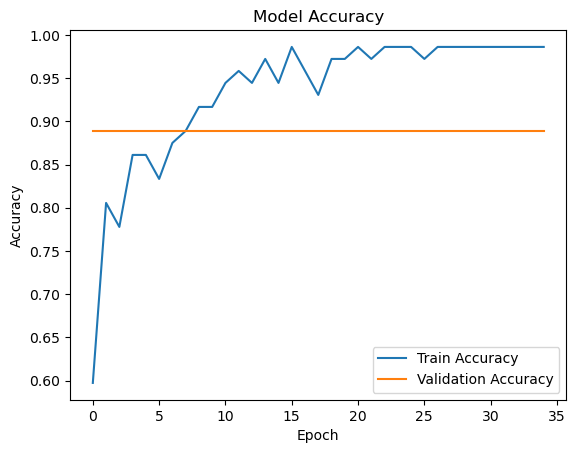

In [14]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

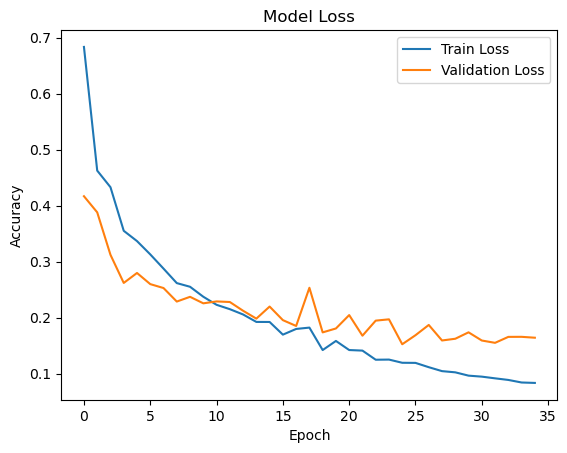

In [15]:
# Plot training & validation accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# VGG19

In [16]:
base_model = VGG19(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Dense layer for feature extraction
predictions = Dense(1, activation='sigmoid')(x)  # Output layer

vgg_model = Model(inputs=base_model.input, outputs=predictions)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

for layer in base_model.layers:
    layer.trainable = False

vgg_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [17]:
history = vgg_model.fit(x_train,y_train,epochs=100,batch_size=12,validation_data=(x_val,y_val),callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 17s 2s/step - loss: 0.7866 - accuracy: 0.5833 - val_loss: 0.4328 - val_accuracy: 0.7778
Epoch 2/100
6/6 [==============================] - 13s 2s/step - loss: 0.5102 - accuracy: 0.7222 - val_loss: 0.2898 - val_accuracy: 0.8889
Epoch 3/100
6/6 [==============================] - 13s 2s/step - loss: 0.3975 - accuracy: 0.7917 - val_loss: 0.2285 - val_accuracy: 0.8889
Epoch 4/100
6/6 [==============================] - 13s 2s/step - loss: 0.3254 - accuracy: 0.8750 - val_loss: 0.1967 - val_accuracy: 0.8889
Epoch 5/100
6/6 [==============================] - 12s 2s/step - loss: 0.2727 - accuracy: 0.8889 - val_loss: 0.2188 - val_accuracy: 0.8889
Epoch 6/100
6/6 [==============================] - 14s 3s/step - loss: 0.2427 - accuracy: 0.9167 - val_loss: 0.1964 - val_accuracy: 0.8889
Epoch 7/100
6/6 [==============================] - 14s 2s/step - loss: 0.2160 - accuracy: 0.9306 - val_loss: 0.1732 - val_accuracy: 0.8889
Epoch 8/100
6/6 [==========

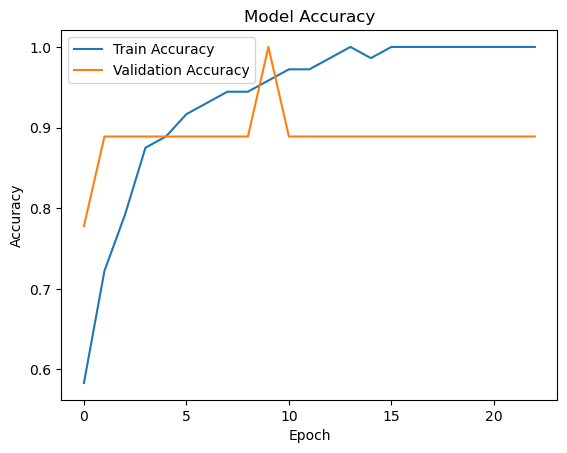

In [18]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

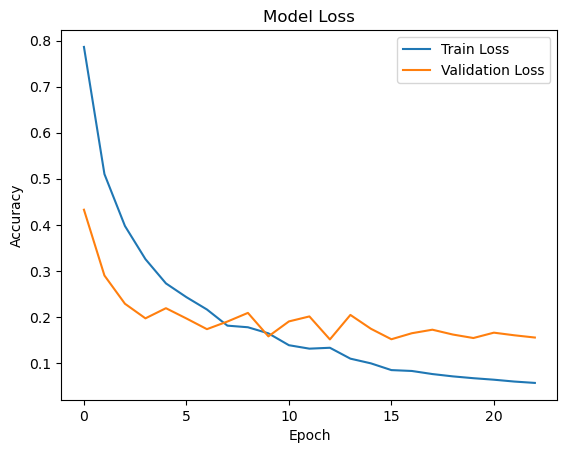

In [19]:
# Plot training & validation accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# InceptionNet

In [20]:
base_model = InceptionV3(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Dense layer for feature extraction
predictions = Dense(1, activation='sigmoid')(x)  # Output layer

inception_model = Model(inputs=base_model.input, outputs=predictions)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

for layer in base_model.layers:
    layer.trainable = False

inception_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [21]:
history = inception_model.fit(x_train,y_train,epochs=100,batch_size=12,validation_data=(x_val,y_val),callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 28s 2s/step - loss: 7.9226 - accuracy: 0.4444 - val_loss: 1.9013 - val_accuracy: 0.6667
Epoch 2/100
6/6 [==============================] - 4s 641ms/step - loss: 4.0942 - accuracy: 0.5417 - val_loss: 4.8626 - val_accuracy: 0.5556
Epoch 3/100
6/6 [==============================] - 4s 745ms/step - loss: 2.7058 - accuracy: 0.6250 - val_loss: 3.7600 - val_accuracy: 0.5556
Epoch 4/100
6/6 [==============================] - 5s 821ms/step - loss: 1.2677 - accuracy: 0.7500 - val_loss: 1.4489 - val_accuracy: 0.7778
Epoch 5/100
6/6 [==============================] - 5s 940ms/step - loss: 0.9163 - accuracy: 0.7361 - val_loss: 0.3939 - val_accuracy: 0.7778
Epoch 6/100
6/6 [==============================] - 4s 644ms/step - loss: 0.8709 - accuracy: 0.7917 - val_loss: 3.0065 - val_accuracy: 0.6667
Epoch 7/100
6/6 [==============================] - 4s 665ms/step - loss: 0.9047 - accuracy: 0.7778 - val_loss: 1.0966 - val_accuracy: 0.6667
Epoch 8/100
6/6

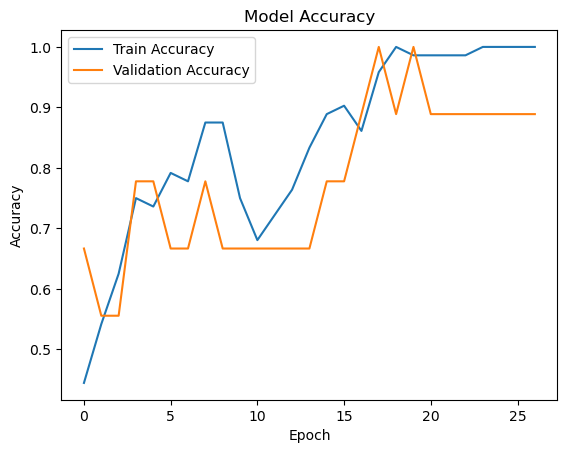

In [22]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

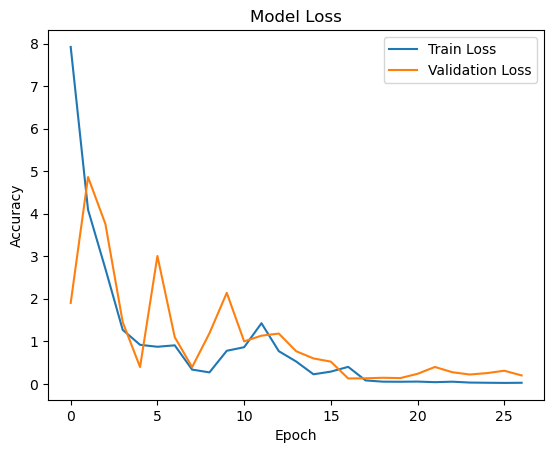

In [23]:
# Plot training & validation accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# MobileNet V3

In [24]:
base_model = MobileNetV3Large(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Dense layer for feature extraction
predictions = Dense(1, activation='sigmoid')(x)  # Output layer

mobilenet_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [25]:
history = mobilenet_model.fit(x_train,y_train,epochs=100,batch_size=12,validation_data=(x_val,y_val),callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 19s 1s/step - loss: 0.7631 - accuracy: 0.5694 - val_loss: 0.5226 - val_accuracy: 0.8889
Epoch 2/100
6/6 [==============================] - 3s 518ms/step - loss: 0.6443 - accuracy: 0.5694 - val_loss: 0.4440 - val_accuracy: 0.8889
Epoch 3/100
6/6 [==============================] - 2s 344ms/step - loss: 0.5665 - accuracy: 0.7083 - val_loss: 0.4701 - val_accuracy: 0.7778
Epoch 4/100
6/6 [==============================] - 2s 383ms/step - loss: 0.4999 - accuracy: 0.8194 - val_loss: 0.4107 - val_accuracy: 0.7778
Epoch 5/100
6/6 [==============================] - 2s 345ms/step - loss: 0.4551 - accuracy: 0.8472 - val_loss: 0.3602 - val_accuracy: 0.7778
Epoch 6/100
6/6 [==============================] - 2s 393ms/step - loss: 0.4250 - accuracy: 0.8194 - val_loss: 0.3473 - val_accuracy: 0.7778
Epoch 7/100
6/6 [==============================] - 2s 413ms/step - loss: 0.4068 - accuracy: 0.8333 - val_loss: 0.3536 - val_accuracy: 0.7778
Epoch 8/100
6/6

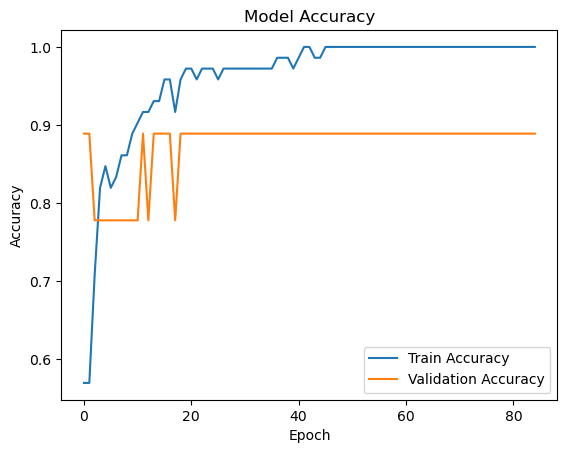

In [26]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

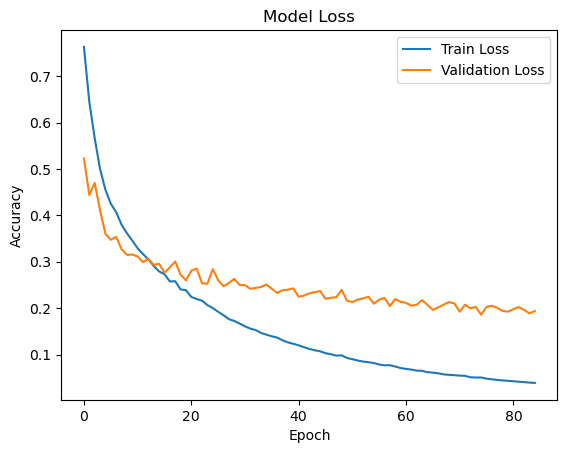

In [27]:
# Plot training & validation accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
ypreds_resnet50 = resnet50_model.predict(x_test)
ypreds_resnet152 = resnet152_model.predict(x_test)
ypreds_mobilenet = mobilenet_model.predict(x_test)
ypreds_inception = inception_model.predict(x_test)
ypreds_vgg19 = vgg_model.predict(x_test)

1/1 [==============================] - 4s 4s/step


In [29]:
ypreds_resnet50 = np.where(ypreds_resnet50>=0.5,1,0) 
ypreds_resnet152 = np.where(ypreds_resnet152>=0.5,1,0)
ypreds_mobilenet = np.where(ypreds_mobilenet>=0.5,1,0)
ypreds_inception = np.where(ypreds_inception>=0.5,1,0)
ypreds_vgg19 =np.where(ypreds_vgg19>=0.5,1,0)

# Metrics for Resnet50

In [30]:
print(f"Accuracy: {accuracy_score(y_test,ypreds_resnet50)}")
print(f"Precision: {precision_score(y_test,ypreds_resnet50)}")
print(f"Recall: {recall_score(y_test,ypreds_resnet50)}")
print(f"F1 Score: {f1_score(y_test,ypreds_resnet50)}")
print(f"ROC Score: {roc_auc_score(y_test,ypreds_resnet50)}")

Accuracy: 0.8571428571428571
Precision: 1.0
Recall: 0.7
F1 Score: 0.8235294117647058
ROC Score: 0.85


<Axes: >

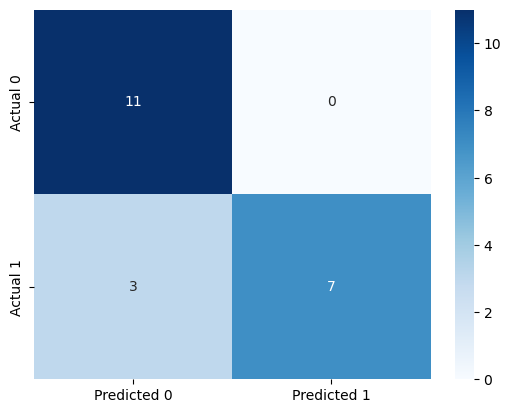

In [31]:
sns.heatmap(confusion_matrix(y_test,ypreds_resnet50),annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

# Metrics for ResNet152

In [32]:
print(f"Accuracy: {accuracy_score(y_test,ypreds_resnet152)}")
print(f"Precision: {precision_score(y_test,ypreds_resnet152)}")
print(f"Recall: {recall_score(y_test,ypreds_resnet152)}")
print(f"F1 Score: {f1_score(y_test,ypreds_resnet152)}")
print(f"ROC Score: {roc_auc_score(y_test,ypreds_resnet152)}")

Accuracy: 0.9047619047619048
Precision: 1.0
Recall: 0.8
F1 Score: 0.888888888888889
ROC Score: 0.9


<Axes: >

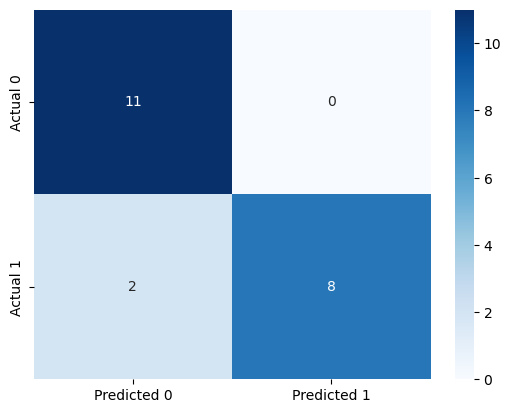

In [33]:
sns.heatmap(confusion_matrix(y_test,ypreds_resnet152),annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

# Metrics for InceptionNet

In [34]:
print(f"Accuracy: {accuracy_score(y_test,ypreds_inception)}")
print(f"Precision: {precision_score(y_test,ypreds_inception)}")
print(f"Recall: {recall_score(y_test,ypreds_inception)}")
print(f"F1 Score: {f1_score(y_test,ypreds_inception)}")
print(f"ROC Score: {roc_auc_score(y_test,ypreds_inception)}")

Accuracy: 0.7619047619047619
Precision: 0.7272727272727273
Recall: 0.8
F1 Score: 0.761904761904762
ROC Score: 0.7636363636363637


<Axes: >

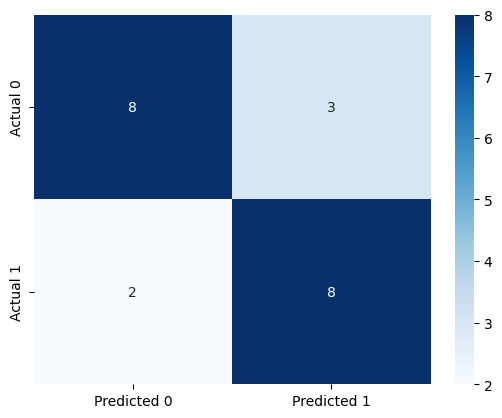

In [35]:
sns.heatmap(confusion_matrix(y_test,ypreds_inception),annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

# Metrics for VGG19

In [36]:
print(f"Accuracy: {accuracy_score(y_test,ypreds_vgg19)}")
print(f"Precision: {precision_score(y_test,ypreds_vgg19)}")
print(f"Recall: {recall_score(y_test,ypreds_vgg19)}")
print(f"F1 Score: {f1_score(y_test,ypreds_vgg19)}")
print(f"ROC Score: {roc_auc_score(y_test,ypreds_vgg19)}")

Accuracy: 0.9047619047619048
Precision: 0.8333333333333334
Recall: 1.0
F1 Score: 0.9090909090909091
ROC Score: 0.9090909090909091


<Axes: >

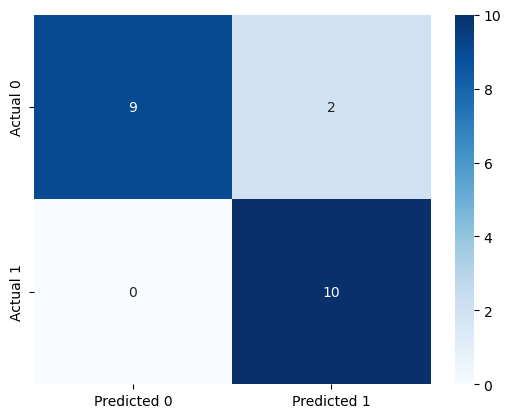

In [37]:
sns.heatmap(confusion_matrix(y_test,ypreds_vgg19),annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

# Metrics for MobileNet V3

In [38]:
print(f"Accuracy: {accuracy_score(y_test,ypreds_mobilenet)}")
print(f"Precision: {precision_score(y_test,ypreds_mobilenet)}")
print(f"Recall: {recall_score(y_test,ypreds_mobilenet)}")
print(f"F1 Score: {f1_score(y_test,ypreds_mobilenet)}")
print(f"ROC Score: {roc_auc_score(y_test,ypreds_mobilenet)}")

Accuracy: 0.7619047619047619
Precision: 0.7777777777777778
Recall: 0.7
F1 Score: 0.7368421052631577
ROC Score: 0.759090909090909


<Axes: >

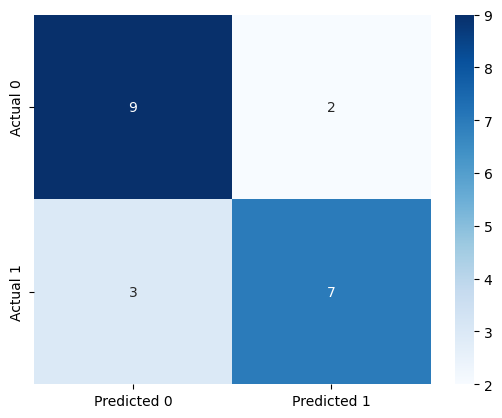

In [39]:
sns.heatmap(confusion_matrix(y_test,ypreds_mobilenet),annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])